In [4]:
from azure.storage.blob import BlobServiceClient
from azure.identity import DefaultAzureCredential

# account_url = "https://storusps.blob.core.windows.net"
account_url = "https://pvtdevelopers.blob.core.windows.net"

# Create a unique name for the container
container_name = "floorplan-resources"

# Create a BlobServiceClient using the local environment's default Azure credentials
credential = DefaultAzureCredential()

# Create a blob client using the local environment's default Azure credentials
service_client = BlobServiceClient(account_url=account_url, credential=credential)

# Create the container
container_client = service_client.get_container_client(container_name)

# List the blobs in the container
blob_list = container_client.list_blobs()

# Store the floorplan and sortplans in a tree structure
floorplans = {}
sortplans = {}

class Node:
    def __init__(self, name, content=None):
        self.name = name
        self.content = content
        self.children = {}
    
def add_path(tree, path, content=None):
    for part in path:
        if part not in tree.children:
            tree.children[part] = Node(part)
        tree = tree.children[part]
    # Add the content to the leaf node
    tree.content = content
    
root = Node("root")

for blob in blob_list:
    # Split the blob name into a list of directories
    path = blob.name.split("/")
    # Load the blob content
    content = container_client.download_blob(blob).readall()
    # Add the path to the tree
    add_path(root, path, content)

def print_tree(node, depth=0):
    print('  ' * depth + node.name)
    for child in node.children.values():
        print_tree(child, depth + 1)

# Print the tree
print_tree(root)

print("Done")

root
  floorplans
    PrimeVision
      handover-belt
        16x3
          floorplan.json
          sortplan.json
        6x3
          floorplan.json
          sortplan.json
      trade-show
        floorplan.json
        sortplan.json
    USPS
      0001_Colorado_Springs
        floorplan.json
        sortplan.json
      0003_Baltimore
        floorplan.json
        sortplan.json
      0016_Fort_Myers
        floorplan.json
        sortplan.json
      0019_Omaha
        floorplan.json
        sortplan.json
      0021_FDR
        floorplan.json
        sortplan.json
      0022_Memphis
        floorplan.json
        floorplan_1.json
        floorplan_2.json
        floorplan_bu.json
        fp-factory
          floorplan.json
          sortplan.json
        sortplan.json
        stable-releases
          floorplan-v1_0.json
          floorplan-v2_0.json
          sortplan.json
        unstable
          floorplan.json
          floorplan_0321_onsite.json
          floorplan_v0_unstab

In [5]:
def find_node(node, path):
    if not path:
        return node
    for child in node.children.values():
        if child.name == path[0]:
            return find_node(child, path[1:])
    return None

def collect_content(node):
    if node.content is not None:
        contents = [node.content]
    else:
        contents = []
    for child in node.children.values():
        contents.extend(collect_content(child))
    return contents

# Replace with the path of the blob you want to find
blob_path = "floorplans/USPS"

# Find the node
node = find_node(root, blob_path.split("/"))

# print all the children of the node
for child in node.children.values():
    print(child.name)
# print all the content of the node
for content in collect_content(node):
    print(content)


0001_Colorado_Springs
0003_Baltimore
0016_Fort_Myers
0019_Omaha
0021_FDR
0022_Memphis
0024_Fayetteville
0025_Des_Moines
0026_Salt_Lake_City
0027_StPaul
0030_San_Diego_MLS
0031_North_Bay
0035_Springdale
0036_Nashua
0041_StThomas
0043_Topeka
00xx_Garside
00xx_Ocala
00xx_Torresdale
b'{\r\n  "zones": [\r\n    {\r\n      "id": "output_gate_1",\r\n      "constraints": {\r\n        "max_velocity": 0.8,\r\n        "max_lateral_acceleration": 0.6,\r\n        "max_corner_size": 1,\r\n        "max_longitudinal_acceleration": 0.8,\r\n        "max_longitudinal_deceleration": 0.6\r\n      },\r\n      "pose": [\r\n        0,\r\n        0,\r\n        0\r\n      ],\r\n      "type": "fixed",\r\n      "nodes": [\r\n        {\r\n          "id": "node_018",\r\n          "type": "target",\r\n          "clear_distance": 0.3,\r\n          "pose": [\r\n            -4.28,\r\n            -4.3,\r\n            1.57\r\n          ],\r\n          "connections": [\r\n            {\r\n              "connects_to": "node

In [47]:
# Replace with the path of the floorplan you want to plot
floorplan_path = "floorplans/USPS/0001_Colorado_Springs"

# Find the node
node = find_node(root, floorplan_path.split("/"))

class TreeNode:
    def __init__(self, id, type, clear_distance, pose, connections, zone):
        self.id = id
        self.type = type
        self.clear_distance = clear_distance
        self.pose = pose
        self.zone = zone 
        self.connections = connections
        self.children = {}
    
    def __str__(self):
        return f"Node {self.id}: {self.type} at {self.pose}"
    def __repr__(self):
        return f"Node {self.id}: {self.type} at {self.pose}"

class Tree:
    def __init__(self):
        self.nodes = {}

    def add_node(self, id, type, clear_distance, pose, connections):
        if id not in self.nodes:
            node = TreeNode(id, type, clear_distance, pose, connections)
            self.nodes[id] = node
        return self.nodes[id]

    def add_edge(self, parent_id, child_id):
        if parent_id in self.nodes and child_id in self.nodes:
            parent = self.nodes[parent_id]
            child = self.nodes[child_id]
            parent.children[child_id] = child
        else:
            print(f"Warning: Attempted to add edge from {parent_id} to {child_id}, but one or both nodes are not in the tree.")
    
    def print_tree(self):
        for node_id in self.nodes:
            self._print_subtree(self.nodes[node_id])

    def _print_subtree(self, node, indent=0):
        print('  ' * indent + str(node))
        for child in node.children.values():
            self._print_subtree(child, indent + 1)


class Bin:
    def __init__(self, id, data):
        self.id = id.split("/")[-1]
        self.type = data["type"]
        self.sub_directions = data["sub_directions"]
    def __str__(self):
        return f"Bin {self.id}: {self.type}"    
    def __repr__(self):
        return f"Bin {self.id}: {self.type}"

tree = Tree()

# Load the json file
import json
floorplan = collect_content(node)[0]
sortplan = collect_content(node)[1]
floorplan = json.loads(floorplan)
sortplan = json.loads(sortplan)

# Hashtable of bins by id
bins = {id: Node(id, node_data) for id, node_data in sortplan.items()}

# Flatten the nodes from the zones
nodes = []
for zone in floorplan["zones"]:
    for node in zone["nodes"]:
        # Add the zone id to the node
        node["zone"] = zone["id"]
        nodes.append(node)

# Add nodes to the tree
for node in nodes:
    tree.add_node(node['id'], node['type'], node['clear_distance'], node['pose'], node['connections'], node['zone'])

# Add edges to the tree
for node in nodes:
    for connection in node['connections']:
        tree.add_edge(node['id'], connection['connects_to'])

tree.print_tree()

Node node_018: target at [-4.28, -4.3, 1.57]
  Node node_019: target at [-4.28, -3.2800000000000002, 1.57]
    Node node_020: target at [-4.28, -2.2299999999999995, 1.57]
      Node node_021: target at [-4.28, -1.2398384770486126, 1.57]
        Node node_022: target at [-4.28, -0.21999999999999975, 1.57]
          Node node_023: target at [-4.28, 0.8, 1.57]
            Node node_024: target at [-4.28, 1.82, 1.57]
              Node node_025: target at [-4.28, 2.84, 1.57]
                Node vljnjt: init at [-4.28, 3.86, 0.7900000000000003]
                  Node node_106a: init at [-3.28, 3.86, 0]
                    Node node_106: init at [-2.28, 3.86, 0]
                      Node 535g17: init at [-1.28, 3.86, 0.7900000000000003]
                        Node node_25: init at [0.1, 3.86, 0.7900000000000001]
                          Node node_103: init at [1.1, 3.86, 0]
                            Node node_102: init at [2.1, 3.86, 0]
                              Node node_27: init 

{'/output_gate_1/node_015': <__main__.Node object at 0x00000174CE025BD0>, '/output_gate_1/node_018': <__main__.Node object at 0x00000174CB6816D0>, '/output_gate_1/node_019': <__main__.Node object at 0x00000174CE025290>, '/output_gate_1/node_020': <__main__.Node object at 0x00000174CE027E90>, '/output_gate_1/node_021': <__main__.Node object at 0x00000174CE025910>, '/output_gate_1/node_022': <__main__.Node object at 0x00000174CE0273D0>, '/output_gate_1/node_030': <__main__.Node object at 0x00000174CE026890>, '/output_gate_1/node_033': <__main__.Node object at 0x00000174CE026E90>, '/output_gate_1/node_034': <__main__.Node object at 0x00000174CE026F50>, '/output_gate_1/node_035': <__main__.Node object at 0x00000174CE026F90>, '/output_gate_1/node_036': <__main__.Node object at 0x00000174CE026FD0>, '/output_gate_1/node_023': <__main__.Node object at 0x00000174CE027F90>, '/output_gate_1/node_038': <__main__.Node object at 0x00000174CE027D50>, '/output_gate_1/node_024': <__main__.Node object a

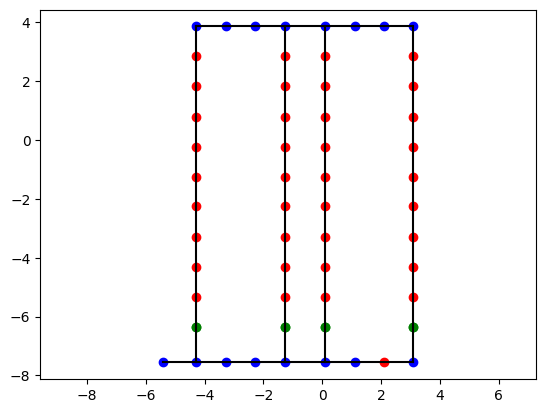

In [51]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class FloorplanPlotter:
    def __init__(self, tree, nodes, color_map):
        self.tree = tree
        self.nodes = nodes
        self.color_map = color_map

    def plot_nodes(self):
        for node in self.nodes:
            plt.scatter(node['pose'][0], node['pose'][1], color=self.color_map.get(node['type'], 'black'))

    def plot_edges(self):
        for node in self.nodes:
            for connection in node['connections']:
                if connection['connects_to'] in self.tree.nodes:
                    start = node['pose'][:2]
                    end = self.tree.nodes[connection['connects_to']].pose[:2]
                    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-')

    def plot_bins(self, bins):
        for node in self.nodes:
            bin = bins.get(node['id'])
            if bin is not None:
                bin_rect = patches.Rectangle((node['pose'][0]-0.15, node['pose'][1]-0.15), 0.3, 0.3, linewidth=1, edgecolor='r', facecolor='none')
                plt.gca().add_patch(bin_rect)
    
    def plot_floorplan(self):
        self.plot_nodes()
        self.plot_edges()
        plt.axis('equal')
        plt.show()

color_map = {
    'init': 'blue',
    'target': 'red',
    'entry_and_exit': 'green'
}

print(bins)

# Create a FloorplanPlotter
plotter = FloorplanPlotter(tree, nodes, color_map)

# Plot the floorplan
plotter.plot_bins(bins)
plotter.plot_floorplan()